In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(10)

In [3]:
# Function that returns the height of the traingle (base_1, base_2, top_point)
def get_triangle_height(base_1: np.array, base_2: np.array, top_point: np.array) -> float:
    # Height of triangle = A/b = ||AB X AC|| / ||AB||
    ab = base_1 - base_2
    ac = base_1 - top_point
    height = np.linalg.norm(np.cross(ab, ac)) / np.linalg.norm(ab)
    return height

# print(get_triangle_height(np.array([0, 0]), np.array([2, 0]), np.array([0, 5])))

5.0


Use the following to be able to sort the vertices of the hull

upper triangle: 0,1 > 2
feret: 91.53420141484435
lower triangle: 2,1 > 1
feret: 96.07053540428706
upper triangle: 1,2 > 1
feret: 60.053376609384166
lower triangle: 1,0 > 2
feret: 55.773727543954074
upper triangle: 2,3 > 0
feret: 60.02551934212807
max feret diameter: 114.0175425099138 | points: [[84.  9.]
 [14. 99.]]
min feret diameter: 55.773727543954074


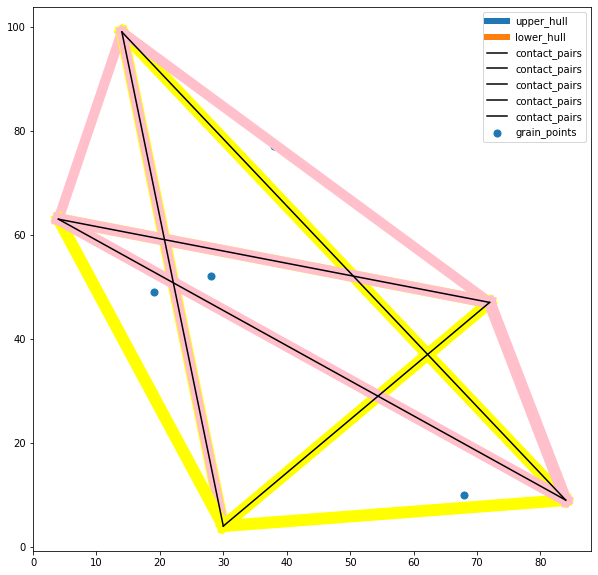

In [7]:

plt.figure(figsize=(10,10))

def is_clockwise(p_1: tuple, p_2: tuple, p_3: tuple) -> bool:
    rotation_matrix = np.array(((p_1[0], p_1[1], 1), (p_2[0], p_2[1], 1), (p_3[0], p_3[1], 1)))
    return not np.linalg.det(rotation_matrix) > 0

# Create array of random but unique coordinates
length = 10
points = np.zeros((length, 2))
for i in range(length):
    while True:
        rand_point = np.array([random.randint(0, 100), random.randint(0, 100)])
        if rand_point not in points:
            points[i] = rand_point
            break

# Square just to check
# points = np.array([[0,0],[0,1],[1,0],[1,1]])

# Sort the vectors by their x coordinate
points = points.tolist()
# print(points)
points.sort()
# points = points[points[:, 0].argsort(0)]
# print(points)
points = np.array(points)
# print(f'points: {points}')

upper_hull = []
lower_hull = []

for point in points:
    while len(lower_hull) > 1 and is_clockwise(lower_hull[-2], lower_hull[-1], point):
        lower_hull.pop()
    lower_hull.append(point)
    while len(upper_hull) > 1 and not is_clockwise(upper_hull[-2], upper_hull[-1], point):
        upper_hull.pop()
    upper_hull.append(point)

upper_hull = np.array(upper_hull)
lower_hull = np.array(lower_hull)
# print('upper hull:')
# print(upper_hull)
# print('lower hull:')
# print(lower_hull)

plt.plot(upper_hull[:, 0], upper_hull[:, 1], linewidth=6, label='upper_hull')
plt.plot(lower_hull[:, 0], lower_hull[:, 1], linewidth=6, label='lower_hull')
    
# Create list of contact vertices for calipers on the antipodal hulls
contact_points = []
upper_index = 0
lower_index = len(lower_hull) - 1
min_ferets = []
# print(f'lower index: {lower_index}')
while upper_index < len(upper_hull) - 1 or lower_index > 0:
    contact_points.append([lower_hull[lower_index, :], upper_hull[upper_index, :]])
    # If we have reached the end of the upper hull, continute iterating over the lower hull
    if upper_index == len(upper_hull) - 1:
        lower_index -= 1
        print(f'lower triangle: {lower_index+1},{lower_index} > {upper_index}')
        small_feret = get_triangle_height(np.array(lower_hull[lower_index+1, :]), np.array(lower_hull[lower_index, :]), np.array(upper_hull[upper_index, :]))
        plt.plot((lower_hull[lower_index+1,0],lower_hull[lower_index,0]),(lower_hull[lower_index+1,1], lower_hull[lower_index,1]), color='yellow', linewidth=10)
        plt.plot((lower_hull[lower_index+1,0],upper_hull[upper_index,0]),(lower_hull[lower_index+1,1],upper_hull[upper_index,1]), color='yellow', linewidth=10)
        plt.plot((lower_hull[lower_index,0],upper_hull[upper_index,0]),(lower_hull[lower_index,1],upper_hull[upper_index,1]), color='yellow', linewidth=10)
        print(f'feret: {small_feret}')
        min_ferets.append(small_feret)
    # If we have reached the end of the lower hull, continue iterating over the upper hull
    elif lower_index == 0:
        upper_index += 1
        print(f'upper triangle: {upper_index-1},{upper_index} > {lower_index}')
        small_feret = get_triangle_height(np.array(upper_hull[upper_index-1, :]), np.array(upper_hull[upper_index, :]), np.array(lower_hull[lower_index, :]))
        plt.plot((upper_hull[upper_index-1,0],lower_hull[lower_index,0]),(upper_hull[upper_index-1,1],lower_hull[lower_index,1]), color='pink', linewidth=12)
        plt.plot((upper_hull[upper_index,0],lower_hull[lower_index,0]),(upper_hull[upper_index,1],lower_hull[lower_index,1]), color='pink', linewidth=12)
        plt.plot((upper_hull[upper_index,0],upper_hull[upper_index-1,0]),(upper_hull[upper_index,1],upper_hull[upper_index-1,1]), color='pink', linewidth=12)
        print(f'feret: {small_feret}')
        min_ferets.append(small_feret)
    # Check if the gradient of the last point and the proposed next point in the upper hull is greater than the gradient
    # of the two corresponding points in the lower hull, if so, this means that the next point in the upper hull
    # will be encountered before the next point in the lower hull and vice versa. 
    # Note that the calcualtion here for gradients is the simple delta upper_y / delta upper_x > delta lower_y / delta lower_x
    # however I have multiplied through the denominators such that there are no instances of division by zero. The
    # inequality still holds and provides what is needed.
    elif (upper_hull[upper_index+1, 1]-upper_hull[upper_index, 1]) * (lower_hull[lower_index, 0] - lower_hull[lower_index-1, 0]) > (lower_hull[lower_index, 1] - lower_hull[lower_index-1, 1]) * (upper_hull[upper_index+1, 0] - upper_hull[upper_index, 0]):
        # If the upper hull is encoutnered first, increment the iteration index for the upper hull
        # Also consider the triangle that is made as the two upper hull vertices are colinear with the caliper
        upper_index += 1
        print(f'upper triangle: {upper_index-1},{upper_index} > {lower_index}')
        small_feret = get_triangle_height(np.array(upper_hull[upper_index-1, :]), np.array(upper_hull[upper_index, :]), np.array(lower_hull[lower_index, :]))
        plt.plot((upper_hull[upper_index-1,0],lower_hull[lower_index,0]),(upper_hull[upper_index-1,1],lower_hull[lower_index,1]), color='pink', linewidth=10)
        plt.plot((upper_hull[upper_index,0],lower_hull[lower_index,0]),(upper_hull[upper_index,1],lower_hull[lower_index,1]), color='pink', linewidth=10)
        plt.plot((upper_hull[upper_index,0],upper_hull[upper_index-1,0]),(upper_hull[upper_index,1],upper_hull[upper_index-1,1]), color='pink', linewidth=10)
        print(f'feret: {small_feret}')
        min_ferets.append(small_feret)

    else:
        # The next point in the lower hull will be encountered first, so increment the lower hull iteration index.
        lower_index -= 1
        print(f'lower triangle: {lower_index+1},{lower_index} > {upper_index}')
        small_feret = get_triangle_height(np.array(lower_hull[lower_index+1, :]), np.array(lower_hull[lower_index, :]), np.array(upper_hull[upper_index, :]))
        plt.plot((lower_hull[lower_index+1,0],lower_hull[lower_index,0]),(lower_hull[lower_index+1,1], lower_hull[lower_index,1]), color='yellow', linewidth=12)
        plt.plot((lower_hull[lower_index+1,0],upper_hull[upper_index,0]),(lower_hull[lower_index+1,1],upper_hull[upper_index,1]), color='yellow', linewidth=12)
        plt.plot((lower_hull[lower_index,0],upper_hull[upper_index,0]),(lower_hull[lower_index,1],upper_hull[upper_index,1]), color='yellow', linewidth=12)
        print(f'feret: {small_feret}')
        min_ferets.append(small_feret)

    # if lower_index == 0 and upper_index == len(upper_hull) - 1:
    #     # Consider last triangle

contact_points = np.array(contact_points)
# print('contact point pairs: ')
# print(contact_points)

for point_pair in contact_points:
    # print(point_pair)
    plt.plot(point_pair[:, 0], point_pair[:, 1], color='black', label='contact_pairs')

# Find the minimum and maximum distance in the contact points
max_dist = None
max_pair = None
for point_pair in contact_points:
    dist = np.sqrt((point_pair[0, 0] - point_pair[1, 0])**2 + (point_pair[0, 1] - point_pair[1, 1])**2)
    if max_dist == None or max_dist < dist:
        max_dist = dist
        max_pair = point_pair

min_feret = min(min_ferets)

print(f'max feret diameter: {max_dist} | points: {max_pair}')
print(f'min feret diameter: {min_feret}')
# plt.plot(max_pair[:, 0], max_pair[:, 1], ':',color='green', label='max_feret', linewidth=5)
# plt.plot(min_pair[:, 0], min_pair[:, 1], '--', color='red', label='min-feret', linewidth=5)
plt.scatter(x=points[:, 0],y=points[:, 1], label='grain_points', s=50)
plt.legend()
plt.show()
